In [1]:
import matplotlib.pyplot as plt
plt.style.use('rcparams.mplstyle')
import matplotlib as mpl
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
import numpy as np
import os
import pickle
import time
from scipy.stats import ncx2, sampling, gaussian_kde
from scipy.optimize import minimize
from pycbc.filter import sigma, sigmasq
from simple_pe_funcs import calculate_mode_snr, network_mode_snr
from interpolating_match import find_min_max, create_2D_interps, find_ecc_range, find_ecc_range_samples
from calcwf import chirp2total, gen_wf, shifted_f, shifted_e_approx, shifted_e, ceiltwo, gen_psd, resize_wfs, get_h

Once again, still needs a lot of cleaning up here.

In [2]:
def favata_et_al_avg(given_e, given_chirp, e_vals, f_low=10, q=2):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Favata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssff = sigmasq(h*h.sample_frequencies**(-7/3), psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-7/6), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssff/ss-(ssf/ss)**2)**(-3/14)
    s_given_e = shifted_e_approx(avg_f, f_low, given_e)
    s_e_vals = shifted_e_approx(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*s_given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*s_e_vals**2)**(3/5)

    return chirp_vals

In [106]:
# Gets 90% confidence bounds (in SNR^2 space) with x% cutoff from left
def dist_CI(rv, x, CI=0.9):
    q = np.array([x, x+CI])
    CI_bounds = rv.ppf(q)
    return CI_bounds

# Gets 90% confidence bounds (in SNR space) with shortest possible distance (in SNR**2 space)
def dist_min_CI(rv, CI=0.9):

    min_result = minimize(lambda x: abs(np.diff(dist_CI(rv, x[0], CI=CI))[0]), 0.05, bounds=[(0,0.1)])
    min_x = min_result['x'][0]

    return np.sqrt(dist_CI(rv, min_x, CI=CI))

# Map match CI to eccentricity CI
def find_ecc_CI(CI_bounds, chirp, interps, slope='increasing', max_ecc=0.2):

    # Find where CI matches cross min and max lines
    min_CI_eccs = find_ecc_range(CI_bounds[0], chirp, interps, slope=slope, max_ecc=max_ecc)
    max_CI_eccs = find_ecc_range(CI_bounds[1], chirp, interps, slope=slope, max_ecc=max_ecc)

    # Find minimum and maximum eccentricity
    min_ecc = np.min([min_CI_eccs, max_CI_eccs])
    max_ecc = np.max([min_CI_eccs, max_CI_eccs])

    return min_ecc, max_ecc

def SNR_samples(obs_SNR, n):

    # Define distribution class
    class SNR_rv():
        def pdf(self, x):
            return ncx2.pdf(x**2, 2, obs_SNR**2)
        def cdf(self, x):
            return ncx2.cdf(x**2, 2, obs_SNR**2)

    # Generate samples
    rv = SNR_rv()
    sample_gen = sampling.NumericalInversePolynomial(rv, center=obs_SNR, domain=(0.000001, np.inf))
    samples = sample_gen.rvs(size=n)
    return samples

def SNR2ecc(matches, chirp, interps, max_ecc=0.2, upper_lenience=0):

    # Find upper and lower bounds on eccentricity for each sample
    ecc_arr = find_ecc_range_samples(matches, chirp, interps, max_ecc=max_ecc)

    # Put upper bound at max_ecc
    max_ecc *= 1+upper_lenience
    inds = ecc_arr>max_ecc
    ecc_arr[inds] = max_ecc

    # Uniformly draw random value between these bounds for each sample
    eccs = np.random.rand(len(matches))*(ecc_arr[1]-ecc_arr[0]) + ecc_arr[0]

    return eccs

In [107]:
# Load grid data
with open(os.path.join('..', 'EccentricBinaries', 'notebooks', 'grid_data', 'dataslot_3', 'all_matches'), 'rb') as fp:
        grid_data_20_30_5 = pickle.load(fp)
grid_data_20_30_5 = find_min_max(grid_data_20_30_5)

# Compute interpolation objects
grid_data_20_30_5_interps = create_2D_interps(grid_data_20_30_5)

In [108]:
# Parameter settings
total_SNR = 40
chirp_mass = 24
ecc = 0.12
MA_shift = 3*np.pi/4
ifos = ['H1']

In [109]:
# Calculate distance for specified SNR
s_d_test = gen_wf(10, ecc, chirp2total(chirp_mass, 2), 2, 4096, 'TEOBResumS', distance=1)
psd_d_test = gen_psd(s_d_test, 10)
s_d_test_sigma = sigma(s_d_test.real(), psd_d_test, low_frequency_cutoff=10, high_frequency_cutoff=psd_d_test.sample_frequencies[-1])
distance = 1*np.sqrt(len(ifos))*s_d_test_sigma/total_SNR

# Calculate strain data (teobresums waveform) and psd
s_f_2pi = 10 - shifted_f(10, ecc, chirp2total(chirp_mass, 2), 2)
s_f = 10 - (MA_shift*s_f_2pi)
s_e = shifted_e(s_f, 10, ecc)
s_teob = gen_wf(s_f, s_e, chirp2total(chirp_mass, 2), 2, 4096, 'TEOBResumS', distance=distance)
chirp_mass_0p1 = favata_et_al_avg(ecc, chirp_mass, 0.1)
fid_wf_len = gen_wf(10, 0.1, chirp2total(chirp_mass_0p1, 2), 2, 4096, 'TEOBResumS', distance=distance)
_, s_teob = resize_wfs([fid_wf_len, s_teob])
psd = gen_psd(s_teob, 10)
s_teob_f = s_teob.real().to_frequencyseries()

# Creates objects used in SNR functions
data = {'H1': s_teob_f, 'L1': s_teob_f}
psds = {'H1': psd, 'L1': psd}
t_start = s_teob.sample_times[0]
t_end = s_teob.sample_times[-1]

In [124]:
# Generates fiducial waveforms in frequency domain
start = time.time()
_, h0, h1, h2, h3, _, _, _, _ = get_h([1,1,1,1], 10, 0.1, chirp2total(chirp_mass_0p1, 2), 2, 4096)
h0_f, h1_f, h2_f, h3_f = [wf.real().to_frequencyseries() for wf in [h0, h1, h2, h3]]
h = {'h0': h0_f, 'h1': h1_f, 'h2': h2_f, 'h3': h3_f}

# Loop over detectors
z = {}
for ifo in ifos:

    # Normalise waveform modes
    h_perp = {}
    for key in h.keys():
        h_perp[key] = h[key] / sigma(h[key], psds[ifo], low_frequency_cutoff=10, high_frequency_cutoff=psds[ifo].sample_frequencies[-1])
    
    # Calculate mode SNRs
    mode_SNRs, _ = calculate_mode_snr(data[ifo], psds[ifo], h_perp, t_start, t_end, 10, h_perp.keys(), dominant_mode='h0')
    z[ifo] = mode_SNRs

# Calculate network SNRs
rss_snr, _ = network_mode_snr(z, ifos, z[ifos[0]].keys(), dominant_mode='h0')

# Draw SNR samples and convert to eccentricity samples
print('rho_{0,4} = ' + str(rss_snr['h0']) + ', rho_{1,4} = ' + str(rss_snr['h1']))
match_samples = SNR_samples(rss_snr['h1'], n=10**6)/rss_snr['h0']
ecc_samples = SNR2ecc(match_samples, 24, grid_data_20_30_5_interps[2], upper_lenience=0.05)

# Compute 90% confidence bounds on h1/h0 SNR
rv = ncx2(2, rss_snr['h1']**2)
h1_CI_bounds = dist_min_CI(rv)
h1_h0_CI_bounds = h1_CI_bounds/rss_snr['h0']

# Compute 90% eccentric CI
ecc_CI_bounds = find_ecc_CI(h1_h0_CI_bounds, chirp_mass_0p1, grid_data_20_30_5_interps[2])

# Output result
end = time.time()
print(f'Eccentricity range of approximately {ecc_CI_bounds[0]:.3f} to {ecc_CI_bounds[1]:.3f} computed in {end-start:.3f} seconds.')

rho_{0,4} = 39.51497538880499, rho_{1,4} = 5.131921842714775
Eccentricity range of approximately 0.075 to 1.000 computed in 11.567 seconds.


In [115]:
def SNR_fill_between(low, high, e_vals, chirp, max_line, interps, c, z):
    SNR_max_e = find_ecc_range(high, chirp, interps)[0]
    SNR_e_vals = e_vals[e_vals<=SNR_max_e]
    SNR_fill_lower = np.full_like(SNR_e_vals, low)
    SNR_fill_lower = np.max([SNR_fill_lower, max_line[e_vals<=SNR_max_e]], axis=0)
    SNR_fill_lower[SNR_fill_lower>high] = high
    plt.fill_between(SNR_e_vals, SNR_fill_lower, high, color=c, zorder=z)

def ecc_fill_between(low, high, chirp, interps, c, z):
    e_vals = np.arange(low, high+0.001, 0.001)
    e_fill_upper = interps[1](chirp, e_vals)
    plt.fill_between(e_vals, 0, e_fill_upper, color=c, zorder=z)

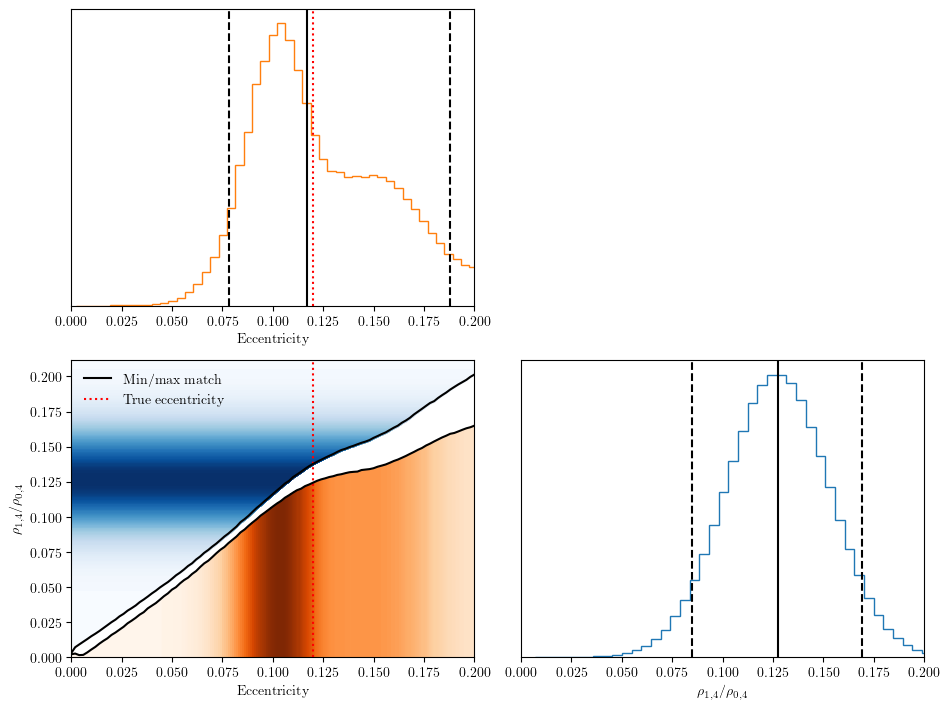

In [127]:
plt.figure(figsize=(6.4*1.5,4.8*1.5))

# Plot interpolated min/max match lines
plt.subplot(2,2,3)
first_chirp = list(data.keys())[0]
# e_vals = grid_data_20_30_5[first_chirp]['e_vals']
e_vals = np.linspace(0, 0.2, 101)
max_line = grid_data_20_30_5_interps[2][0](chirp_mass, e_vals)
min_line = grid_data_20_30_5_interps[2][1](chirp_mass, e_vals)
plt.plot(e_vals, max_line, c='k', zorder=3, label='Min/max match')
plt.plot(e_vals, min_line, c='k', zorder=3)
plt.axvline(ecc, c='r', ls='dotted', label='True eccentricity')
ylims = plt.gca().get_ylim()

# Plot SNR distribution
kde = gaussian_kde(match_samples)
match_vals = np.arange(0, np.max(match_samples)+0.001, 0.001)
kde_vals = kde(match_vals)
kde_max = np.max(kde_vals)
cmap = mpl.colormaps['Blues_r']
SNR_fill_between(0, 1, e_vals, chirp_mass, max_line, grid_data_20_30_5_interps[2], cmap(0.999), -100)
for i in range(99):
    idx = np.argwhere(np.diff(np.sign(kde_vals - kde_max*(99-i)/100))).flatten()
    if len(idx) == 0:
        continue
    if kde_vals[idx[0]] > kde_vals[idx[0]+1]:
        SNR_fill_between(0, match_vals[idx[0]], e_vals, chirp_mass, max_line, grid_data_20_30_5_interps[2], cmap(i/100), -i)
        idx = idx[1:]
        if len(idx) == 0:
            continue
    if kde_vals[idx[-1]+1] > kde_vals[idx[-1]]:
        SNR_fill_between(match_vals[idx[-1]], 1, e_vals, chirp_mass, max_line, grid_data_20_30_5_interps[2], cmap(i/100), -i)
        idx = idx[:-1]
        if len(idx) == 0:
            continue
    for j in range(0, len(idx), 2):
        SNR_fill_between(match_vals[idx[j]], match_vals[idx[j+1]], e_vals, chirp_mass, max_line, grid_data_20_30_5_interps[2], cmap(i/100), -i)

# Plot ecc distribution
kde = gaussian_kde(ecc_samples)
ecc_vals = np.arange(0, np.max(ecc_samples)+0.001, 0.001)
kde_vals = kde(ecc_vals)
kde_max = np.max(kde_vals)
cmap = mpl.colormaps['Oranges_r']
ecc_fill_between(e_vals[0], e_vals[-1], chirp_mass, grid_data_20_30_5_interps[2], cmap(0.999), -100)
for i in range(99):
    idx = np.argwhere(np.diff(np.sign(kde_vals - kde_max*(99-i)/100))).flatten()
    if len(idx) == 0:
        continue
    if kde_vals[idx[0]] > kde_vals[idx[0]+1]:
        ecc_fill_between(0, ecc_vals[idx[0]], chirp_mass, grid_data_20_30_5_interps[2], cmap(i/100), -i)
        idx = idx[1:]
        if len(idx) == 0:
            continue
    if kde_vals[idx[-1]+1] > kde_vals[idx[-1]]:
        ecc_fill_between(ecc_vals[idx[-1]], 1, chirp_mass, grid_data_20_30_5_interps[2], cmap(i/100), -i)
        idx = idx[:-1]
        if len(idx) == 0:
            continue
    for j in range(0, len(idx), 2):
        ecc_fill_between(ecc_vals[idx[j]], ecc_vals[idx[j+1]], chirp_mass, grid_data_20_30_5_interps[2], cmap(i/100), -i)

# Plot formatting
plt.xlabel('Eccentricity')
plt.ylabel(r'$\rho_{1,4} / \rho_{0,4}$')
plt.xlim(e_vals[0], e_vals[-1])
plt.ylim(0,ylims[1])
plt.legend(frameon=False)

# SNR histogram
plt.subplot(2,2,4)
fig=plt.hist(match_samples, bins=50, histtype='step', color='C0')
plt.xlim(0,0.2)
quantiles = np.quantile(match_samples, [0.05, 0.5, 0.95])
plt.axvline(quantiles[0], c='k', ls='dashed')
plt.axvline(quantiles[1], c='k', ls='solid')
plt.axvline(quantiles[2], c='k', ls='dashed')
plt.gca().yaxis.set_visible(False)
plt.xlabel(r'$\rho_{1,4} / \rho_{0,4}$')

# Ecc histogram
plt.subplot(2,2,1)
fig=plt.hist(ecc_samples, bins=50, histtype='step', color='C1')
plt.xlim(0,0.2)
quantiles = np.quantile(ecc_samples, [0.05, 0.5, 0.95])
plt.axvline(quantiles[0], c='k', ls='dashed')
plt.axvline(quantiles[1], c='k', ls='solid')
plt.axvline(quantiles[2], c='k', ls='dashed')
plt.axvline(ecc, c='r', ls='dotted')
plt.gca().yaxis.set_visible(False)
plt.xlabel('Eccentricity')

# General formatting
# plt.suptitle(f'SNR={total_SNR}' + ', $\mathcal{M}=$' + str(chirp_mass) + ', $e=$' + str(ecc))
plt.tight_layout()

# Save figure
# plt.savefig('Figures/SNR2ecc_3.png', dpi=1000)